学习和使用支持向量机

- 学习教材6.3、6.4节内容，调试运行相关代码。
- 查阅scikit-learn工具包中支持向量机的相关说明，了解分类器函数使用方法。
- 完成作业二


# SMO高效优化算法

> 书本代码参考仓库[Machine Learning in Action](https://github.com/TeFuirnever/Machine-Learning-in-Action)

SMO算法的目标是求出一系列alpha和b，便于计算权重向量并得到分隔超平面。

工作原理：选择两个alpha进行优化处理，一旦找到一对合适的alpha，那么就增大一个减少另一个。

> “合适”：①alpha须在间隔边界之外；②alpha没有进行过区间化处理或者不在边界上。


## 简化版SMO

量少，但执行速度慢。跳过SMO的外循环（确定最佳alpha对），遍历每个alpha随机选择另一个。

In [1]:
import numpy as np
import random

In [2]:
## 6-1 SMO算法中的辅助函数
"""
函数说明:读取数据
Parameters:
    fileName - 文件名
Returns:
    dataMat - 数据矩阵
    labelMat - 数据标签
"""
def loadDataSet(fileName):
    dataMat = []; labelMat = []
    fr = open(fileName)
    for line in fr.readlines():                                     #逐行读取，滤除空格等
        lineArr = line.strip().split('\t')
        dataMat.append([float(lineArr[0]), float(lineArr[1])])      #添加数据
        labelMat.append(float(lineArr[2]))                          #添加标签
    return dataMat,labelMat

"""
函数说明:随机选择alpha
Parameters:
    i - alpha
    m - alpha参数个数
Returns:
    j -
"""
def selectJrand(i, m):
    j = i                                 #选择一个不等于i的j
    while (j == i):
        j = int(random.uniform(0, m))
    return j

"""
函数说明:修剪alpha
Parameters:
    aj - alpha值
    H - alpha上限
    L - alpha下限
Returns:
    aj - alpah值
"""
def clipAlpha(aj,H,L):
    if aj > H:
        aj = H
    if L > aj:
        aj = L
    return aj


In [3]:
dataArr, labelArr = loadDataSet('./data/testSet.txt')
print(labelArr[:5])

[-1.0, -1.0, 1.0, -1.0, 1.0]


该数据集中类别标签为1，-1。

SMO的伪代码大致如下：

> * 创建一个alpha向量并将其初始化为0向量
> 
> * 当迭代次数小于最大迭代次数时：
>
>   * 对数据集中的每个数据向量（外循环）：
>
>     * 如果该向量可以被优化：
>
>       * 随机选择另外一个数据向量（内循环）
>
>       * 同时优化这两个向量
>
>       * 如果两个向量都不能被优化，退出内循环
>
> * 如果所有向量都没有被优化，增加迭代数目，继续下一次循环

$$
fXi = \sum_{j=1}^N \alpha_j y_j X_j \cdot X_i
$$

步骤1：计算误差Ei=f(x)-y

步骤2：计算上下界L和H
$$
L = \max{(0,\alpha_2^{\text{old}}-\alpha_1^{\text{old}})}, \ \ \ H=\min{(C,C+\alpha_2^{\text{old}}-\alpha_1^{\text{old}})}\\
或\\
L = \max{(0,\alpha_2^{\text{old}}+\alpha_1^{\text{old}}-C)}, \ \ \ H=\min{(C,\alpha_2^{\text{old}}+\alpha_1^{\text{old}})}
$$

步骤3：计算eta(η)
$$
\eta = K_{11} + K_{22} - 2K_{12} = ||\phi(x_1)-\phi(x_2)||^2
$$

步骤4：更新alpha_j
$$
\alpha_2^{\text{new,unc}} = \alpha_2^{\text{old}} + \dfrac{y_2(E_1-E_2)}{\eta}
$$

步骤5：修剪alpha_j
$$
\alpha_2^{new} = \left\{ 
\begin{align}
&H,  &\alpha_2^{\text{new,unc}}\gt H \\
&\alpha_2^{\text{new,unc}}, & L \le\alpha_2^{\text{new,unc}}\le H \\
&L, &\alpha_2^{\text{new,unc}}\lt L
\end{align}
\right.
$$

步骤6：更新alpha_i
$$
\alpha_1^{\text{new}} = \alpha_1^{\text{old}} + y_1y_2(\alpha_2^{\text{old}}-\alpha_2^{\text{new}})
$$

步骤7：更新b_1和b_2
$$
b_1^{\text{new}} = b^{\text{old}} - E_1 - y_1K_{11}(\alpha_1^{\text{new}}-\alpha_1^{\text{old}}) - y_2K_{21}(\alpha_2^{\text{new}}-\alpha_2^{\text{old}})\\
b_2^{\text{new}} = b^{\text{old}} - E_2 - y_1K_{12}(\alpha_1^{\text{new}}-\alpha_1^{\text{old}}) - y_2K_{22}(\alpha_2^{\text{new}}-\alpha_2^{\text{old}})\\           
$$

步骤8：根据b_1和b_2更新b

In [4]:
"""
函数说明:简化版SMO算法
Parameters:
    dataMatIn - 数据矩阵
    classLabels - 数据标签
    C - 松弛变量
    toler - 容错率
    maxIter - 最大迭代次数
Returns:
    无
"""
def smoSimple(dataMatIn, classLabels, C, toler, maxIter):
    #转换为numpy的mat存储
    dataMatrix = np.mat(dataMatIn); labelMat = np.mat(classLabels).transpose()
    #初始化b参数，统计dataMatrix的维度
    b = 0; m,n = np.shape(dataMatrix)
    #初始化alpha参数，设为0
    alphas = np.mat(np.zeros((m,1)))
    #初始化迭代次数
    iter_num = 0
    #最多迭代matIter次
    while (iter_num < maxIter):
        alphaPairsChanged = 0
        for i in range(m):
            #步骤1：计算误差Ei
            fXi = float(np.multiply(alphas,labelMat).T*(dataMatrix*dataMatrix[i,:].T)) + b
            ##fXi = \sum_{j=1}^N \alpha_j y_j X_j \cdot X_i X:Vector
            Ei = fXi - float(labelMat[i])
            #优化alpha，更设定一定的容错率。
            if ((labelMat[i]*Ei < -toler) and (alphas[i] < C)) or ((labelMat[i]*Ei > toler) and (alphas[i] > 0)):
                #随机选择另一个与alpha_i成对优化的alpha_j
                j = selectJrand(i,m)
                #步骤1：计算误差Ej
                fXj = float(np.multiply(alphas,labelMat).T*(dataMatrix*dataMatrix[j,:].T)) + b
                Ej = fXj - float(labelMat[j])
                #保存更新前的aplpha值，使用深拷贝
                alphaIold = alphas[i].copy(); alphaJold = alphas[j].copy();
                #步骤2：计算上下界L和H
                if (labelMat[i] != labelMat[j]):
                    L = max(0, alphas[j] - alphas[i])
                    H = min(C, C + alphas[j] - alphas[i])
                else:
                    L = max(0, alphas[j] + alphas[i] - C)
                    H = min(C, alphas[j] + alphas[i])
                ## L = \max{(0,\alpha_2^{\text{old}}-\alpha_1^{\text{old}})}, \ \ \ H=\min{(C,C+\alpha_2^{\text{old}}-\alpha_1^{\text{old}})}
                ## L = \max{(0,\alpha_2^{\text{old}}+\alpha_1^{\text{old}}-C)}, \ \ \ H=\min{(C,\alpha_2^{\text{old}}+\alpha_1^{\text{old}})}
                if L==H: print("L==H"); continue
                #步骤3：计算eta(η)
                eta = 2.0 * dataMatrix[i,:]*dataMatrix[j,:].T - dataMatrix[i,:]*dataMatrix[i,:].T - dataMatrix[j,:]*dataMatrix[j,:].T
                ## \eta = K_{11} + K_{22} - 2K_{12} = ||\phi(x_1)-\phi(x_2)||^2
                if eta >= 0: print("eta>=0"); continue
                #步骤4：更新alpha_j
                alphas[j] -= labelMat[j]*(Ei - Ej)/eta
                ## \alpha_2^{\text{new,unc}} = \alpha_2^{\text{old}} + \dfrac{y_2(E_1-E_2)}{\eta}
                #步骤5：修剪alpha_j
                alphas[j] = clipAlpha(alphas[j],H,L)
                if (abs(alphas[j] - alphaJold) < 0.00001): print("alpha_j变化太小"); continue
                #步骤6：更新alpha_i
                alphas[i] += labelMat[j]*labelMat[i]*(alphaJold - alphas[j])
                ## \alpha_1^{\text{new}} = \alpha_1^{\text{old}} + y_1y_2(\alpha_2^{\text{old}}-\alpha_2^{\text{new}})
                #步骤7：更新b_1和b_2
                b1 = b - Ei- labelMat[i]*(alphas[i]-alphaIold)*dataMatrix[i,:]*dataMatrix[i,:].T - labelMat[j]*(alphas[j]-alphaJold)*dataMatrix[i,:]*dataMatrix[j,:].T
                b2 = b - Ej- labelMat[i]*(alphas[i]-alphaIold)*dataMatrix[i,:]*dataMatrix[j,:].T - labelMat[j]*(alphas[j]-alphaJold)*dataMatrix[j,:]*dataMatrix[j,:].T
                ##b_1^{\text{new}} = b^{\text{old}} - E_1 - y_1K_{11}(\alpha_1^{\text{new}}-\alpha_1^{\text{old}}) - y_2K_{21}(\alpha_2^{\text{new}}-\alpha_2^{\text{old}})\\
                ##b_2^{\text{new}} = b^{\text{old}} - E_2 - y_1K_{12}(\alpha_1^{\text{new}}-\alpha_1^{\text{old}}) - y_2K_{22}(\alpha_2^{\text{new}}-\alpha_2^{\text{old}})\\
                #步骤8：根据b_1和b_2更新b
                if (0 < alphas[i]) and (C > alphas[i]): b = b1
                elif (0 < alphas[j]) and (C > alphas[j]): b = b2
                else: b = (b1 + b2)/2.0
                #统计优化次数
                alphaPairsChanged += 1
                #打印统计信息
                print("第%d次迭代 样本:%d, alpha优化次数:%d" % (iter_num,i,alphaPairsChanged))
        #更新迭代次数
        if (alphaPairsChanged == 0): iter_num += 1
        else: iter_num = 0
        print("迭代次数: %d" % iter_num)
    return b,alphas

进行简单的测试：

In [5]:
%%time
b, alphas = smoSimple(dataArr, labelArr, 0.6, 0.001, 40)

第0次迭代 样本:0, alpha优化次数:1
alpha_j变化太小
alpha_j变化太小
第0次迭代 样本:5, alpha优化次数:2
L==H
L==H
L==H
第0次迭代 样本:23, alpha优化次数:3
第0次迭代 样本:24, alpha优化次数:4
第0次迭代 样本:25, alpha优化次数:5
第0次迭代 样本:26, alpha优化次数:6
alpha_j变化太小
第0次迭代 样本:31, alpha优化次数:7
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
第0次迭代 样本:56, alpha优化次数:8
L==H
alpha_j变化太小
L==H
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
L==H
alpha_j变化太小
迭代次数: 0
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
L==H
L==H
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
L==H
alpha_j变化太小
L==H
L==H
alpha_j变化太小
L==H
alpha_j变化太小
L==H
alpha_j变化太小
alpha_j变化太小
L==H
迭代次数: 1
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
第1次迭代 样本:10, alpha优化次数:1
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
第1次迭代 样本:29, alpha优化次数:2
第1次迭代 样本:54, alpha优化次数:3
第1次迭代 样本:55, alpha优化次数:4
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
L==H
迭代次数: 0
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
L==H
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
L==H
alpha_j变化太小
第0次迭代

alpha_j变化太小
第6次迭代 样本:29, alpha优化次数:1
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 0
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 1
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 2
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 3
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 4
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 5
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 6
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 7
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 8
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 9
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 10
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 11
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 12
alpha_j变化太小
alpha_j变化太小
alph

In [6]:
b

matrix([[-3.90043157]])

In [7]:
alphas[alphas>0]

matrix([[0.10104876, 0.26933193, 0.03268721, 0.33769349]])

## 完整Platt SMO

简化版SMO中，外层循环是遍历所有样本点作为 $\alpha_i$ ，内层循环则是随机选择 $\alpha_j$ 更新这两个 $\alpha$ 。这样做计算速度较慢，在较大量数据集或维度较高数据集中很可能耗时过多。

完整版的Platt SMO的外层循环是遍历所有样本点和遍历非边界点交替进行，遍历所有样本点之后就遍历所有非边界点，遍历非边界点之后如果没有 $\alpha$ 被更新则重新遍历所有样本点；否则继续遍历非边界点。

内循环则不是随机选择，是通过计算最大化步长 $|E_i-E_j|$ 来进行选择，选择使得 $|E_i-E_j|$ 最大的点作为 $\alpha_j$。

简化版和完整版仅在 $\alpha$ 的选择上有所不同，内部计算和更新方法相同，不再赘述。但是后者的计算效率相对较高。

In [8]:
## 6-3 完整版SMO的支持函数
"""
数据结构，维护所有需要操作的值
Parameters：
    dataMatIn - 数据矩阵
    classLabels - 数据标签
    C - 松弛变量
    toler - 容错率
"""
class optStruct:
    def __init__(self, dataMatIn, classLabels, C, toler):
        self.X = dataMatIn                                #数据矩阵
        self.labelMat = classLabels                        #数据标签
        self.C = C                                         #松弛变量
        self.tol = toler                                 #容错率
        self.m = np.shape(dataMatIn)[0]                 #数据矩阵行数
        self.alphas = np.mat(np.zeros((self.m,1)))         #根据矩阵行数初始化alpha参数为0
        self.b = 0                                         #初始化b参数为0
        self.eCache = np.mat(np.zeros((self.m,2)))         #根据矩阵行数初始化虎误差缓存，第一列为是否有效的标志位，第二列为实际的误差E的值。

"""
读取数据
Parameters:
    fileName - 文件名
Returns:
    dataMat - 数据矩阵
    labelMat - 数据标签
"""     
def loadDataSet(fileName):
    dataMat = []; labelMat = []
    fr = open(fileName)
    for line in fr.readlines():                                     #逐行读取，滤除空格等
        lineArr = line.strip().split('\t')
        dataMat.append([float(lineArr[0]), float(lineArr[1])])      #添加数据
        labelMat.append(float(lineArr[2]))                          #添加标签
    return dataMat,labelMat


"""
计算误差
Parameters：
    oS - 数据结构
    k - 标号为k的数据
Returns:
    Ek - 标号为k的数据误差
"""
def calcEk(oS, k):
    fXk = float(np.multiply(oS.alphas,oS.labelMat).T*(oS.X*oS.X[k,:].T) + oS.b)
    Ek = fXk - float(oS.labelMat[k])
    return Ek

"""
内循环启发方式2
Parameters：
    i - 标号为i的数据的索引值
    oS - 数据结构
    Ei - 标号为i的数据误差
Returns:
    j, maxK - 标号为j或maxK的数据的索引值
    Ej - 标号为j的数据误差
"""
def selectJ(i, oS, Ei):
    maxK = -1; maxDeltaE = 0; Ej = 0                         #初始化
    oS.eCache[i] = [1,Ei]                                      #根据Ei更新误差缓存
    validEcacheList = np.nonzero(oS.eCache[:,0].A)[0]        #返回误差不为0的数据的索引值
    if (len(validEcacheList)) > 1:                            #有不为0的误差
        for k in validEcacheList:                           #遍历,找到最大的Ek
            if k == i: continue                             #不计算i,浪费时间
            Ek = calcEk(oS, k)                                #计算Ek
            deltaE = abs(Ei - Ek)                            #计算|Ei-Ek|
            if (deltaE > maxDeltaE):                        #找到maxDeltaE
                maxK = k; maxDeltaE = deltaE; Ej = Ek
        return maxK, Ej                                        #返回maxK,Ej
    else:                                                   #没有不为0的误差
        j = selectJrand(i, oS.m)                            #随机选择alpha_j的索引值
        Ej = calcEk(oS, j)                                    #计算Ej
    return j, Ej                                             #j,Ej

"""
计算Ek,并更新误差缓存
Parameters：
    oS - 数据结构
    k - 标号为k的数据的索引值
Returns:
    无
"""
def updateEk(oS, k):
    Ek = calcEk(oS, k)                                        #计算Ek
    oS.eCache[k] = [1,Ek]                                    #更新误差缓存

In [9]:
## 6-4 完整Platt SMO算法中的优化例程
"""
优化的SMO算法
Parameters：
    i - 标号为i的数据的索引值
    oS - 数据结构
Returns:
    1 - 有任意一对alpha值发生变化
    0 - 没有任意一对alpha值发生变化或变化太小
"""
def innerL(i, oS):
    #步骤1：计算误差Ei
    Ei = calcEk(oS, i)
    #优化alpha,设定一定的容错率。
    if ((oS.labelMat[i] * Ei < -oS.tol) and (oS.alphas[i] < oS.C)) or ((oS.labelMat[i] * Ei > oS.tol) and (oS.alphas[i] > 0)):
        #使用内循环启发方式2选择alpha_j,并计算Ej
        j,Ej = selectJ(i, oS, Ei)
        #保存更新前的aplpha值，使用深拷贝
        alphaIold = oS.alphas[i].copy(); alphaJold = oS.alphas[j].copy();
        #步骤2：计算上下界L和H
        if (oS.labelMat[i] != oS.labelMat[j]):
            L = max(0, oS.alphas[j] - oS.alphas[i])
            H = min(oS.C, oS.C + oS.alphas[j] - oS.alphas[i])
        else:
            L = max(0, oS.alphas[j] + oS.alphas[i] - oS.C)
            H = min(oS.C, oS.alphas[j] + oS.alphas[i])
        if L == H:
            print("L==H")
            return 0
        #步骤3：计算eta
        eta = 2.0 * oS.X[i,:] * oS.X[j,:].T - oS.X[i,:] * oS.X[i,:].T - oS.X[j,:] * oS.X[j,:].T
        if eta >= 0:
            print("eta>=0")
            return 0
        #步骤4：更新alpha_j
        oS.alphas[j] -= oS.labelMat[j] * (Ei - Ej)/eta
        #步骤5：修剪alpha_j
        oS.alphas[j] = clipAlpha(oS.alphas[j],H,L)
        #更新Ej至误差缓存
        updateEk(oS, j)
        if (abs(oS.alphas[j] - alphaJold) < 0.00001):
            print("alpha_j变化太小")
            return 0
        #步骤6：更新alpha_i
        oS.alphas[i] += oS.labelMat[j]*oS.labelMat[i]*(alphaJold - oS.alphas[j])
        #更新Ei至误差缓存
        updateEk(oS, i)
        #步骤7：更新b_1和b_2
        b1 = oS.b - Ei- oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.X[i,:]*oS.X[i,:].T - oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.X[i,:]*oS.X[j,:].T
        b2 = oS.b - Ej- oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.X[i,:]*oS.X[j,:].T - oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.X[j,:]*oS.X[j,:].T
        #步骤8：根据b_1和b_2更新b
        if (0 < oS.alphas[i]) and (oS.C > oS.alphas[i]): oS.b = b1
        elif (0 < oS.alphas[j]) and (oS.C > oS.alphas[j]): oS.b = b2
        else: oS.b = (b1 + b2)/2.0
        return 1
    else:
        return 0

In [10]:
"""
完整的线性SMO算法
Parameters：
    dataMatIn - 数据矩阵
    classLabels - 数据标签
    C - 松弛变量
    toler - 容错率
    maxIter - 最大迭代次数
Returns:
    oS.b - SMO算法计算的b
    oS.alphas - SMO算法计算的alphas
"""
def smoP(dataMatIn, classLabels, C, toler, maxIter):
    oS = optStruct(np.mat(dataMatIn), np.mat(classLabels).transpose(), C, toler)                    #初始化数据结构
    iter = 0                                                                                         #初始化当前迭代次数
    entireSet = True; alphaPairsChanged = 0
    while (iter < maxIter) and ((alphaPairsChanged > 0) or (entireSet)):                            #遍历整个数据集都alpha也没有更新或者超过最大迭代次数,则退出循环
        alphaPairsChanged = 0
        if entireSet:                                                                                #遍历整个数据集
            for i in range(oS.m):# 对数据集中的所有行
                alphaPairsChanged += innerL(i,oS)                                                    #使用优化的SMO算法
                print("全样本遍历:第%d次迭代 样本:%d, alpha优化次数:%d" % (iter,i,alphaPairsChanged))
            iter += 1
        else:                                                                                         #遍历非边界值
            nonBoundIs = np.nonzero((oS.alphas.A > 0) * (oS.alphas.A < C))[0]                        #遍历不在边界0和C的alpha
            for i in nonBoundIs:
                alphaPairsChanged += innerL(i,oS)
                print("非边界遍历:第%d次迭代 样本:%d, alpha优化次数:%d" % (iter,i,alphaPairsChanged))
            iter += 1
        if entireSet:                                                                                #遍历一次后改为非边界遍历
            entireSet = False
        elif (alphaPairsChanged == 0):                                                                #如果alpha没有更新,计算全样本遍历
            entireSet = True
        print("迭代次数: %d" % iter)
    return oS.b,oS.alphas                                                                             #返回SMO算法计算的b和alphas

测试

In [11]:
%%time
dataArr, labelArr = loadDataSet('./data/testSet.txt')
b, alphas = smoP(dataArr, labelArr, 0.6, 0.001, 40)

全样本遍历:第0次迭代 样本:0, alpha优化次数:1
全样本遍历:第0次迭代 样本:1, alpha优化次数:1
全样本遍历:第0次迭代 样本:2, alpha优化次数:2
全样本遍历:第0次迭代 样本:3, alpha优化次数:3
全样本遍历:第0次迭代 样本:4, alpha优化次数:4
全样本遍历:第0次迭代 样本:5, alpha优化次数:5
全样本遍历:第0次迭代 样本:6, alpha优化次数:5
全样本遍历:第0次迭代 样本:7, alpha优化次数:5
全样本遍历:第0次迭代 样本:8, alpha优化次数:6
全样本遍历:第0次迭代 样本:9, alpha优化次数:6
L==H
全样本遍历:第0次迭代 样本:10, alpha优化次数:6
全样本遍历:第0次迭代 样本:11, alpha优化次数:6
全样本遍历:第0次迭代 样本:12, alpha优化次数:6
全样本遍历:第0次迭代 样本:13, alpha优化次数:6
全样本遍历:第0次迭代 样本:14, alpha优化次数:6
全样本遍历:第0次迭代 样本:15, alpha优化次数:7
全样本遍历:第0次迭代 样本:16, alpha优化次数:7
L==H
全样本遍历:第0次迭代 样本:17, alpha优化次数:7
全样本遍历:第0次迭代 样本:18, alpha优化次数:8
全样本遍历:第0次迭代 样本:19, alpha优化次数:8
全样本遍历:第0次迭代 样本:20, alpha优化次数:8
全样本遍历:第0次迭代 样本:21, alpha优化次数:8
全样本遍历:第0次迭代 样本:22, alpha优化次数:8
L==H
全样本遍历:第0次迭代 样本:23, alpha优化次数:8
全样本遍历:第0次迭代 样本:24, alpha优化次数:8
alpha_j变化太小
全样本遍历:第0次迭代 样本:25, alpha优化次数:8
L==H
全样本遍历:第0次迭代 样本:26, alpha优化次数:8
全样本遍历:第0次迭代 样本:27, alpha优化次数:8
全样本遍历:第0次迭代 样本:28, alpha优化次数:8
L==H
全样本遍历:第0次迭代 样本:29, alpha优化次数:8
全样本遍历:第0次迭代 样本:30, alpha优化次数:8
全样本遍历:第0次迭代 

用时方面，在相同配置的主机上，时间从7秒下降到了不到0.3秒。

利用计算得到的alpha值，可以计算w用于构建超平面。

In [12]:
def calcWs(alphas, dataArr, classLabels):
    X = np.mat(dataArr); labelMat = np.mat(classLabels).transpose()
    m,n = X.shape
    w = np.zeros((n,1))
    for i in range(m):
        w += np.multiply(alphas[i]*labelMat[i],X[i,:].T)
    return w

In [13]:
ws = calcWs(alphas,dataArr,labelArr)
ws

array([[ 0.65263178],
       [-0.17581327]])

分类

In [14]:
datMat = np.mat(dataArr)
print(datMat[0]*np.mat(ws)+b)

[[-0.93044397]]


若该值大于0，其属于1类；若该值小于0，属于-1类，这里得到的分类结果是-1，我们验证一下是不是一样的：

In [15]:
labelArr[0]

-1.0

# SVM in scikit-learn

查阅scikit-learn工具包中支持向量机的相关说明，了解分类器函数使用方法。

参考这一篇进行学习：[机器学习笔记3-sklearn支持向量机](https://www.jianshu.com/p/a9f9954355b3?utm_campaign=maleskine&utm_content=note&utm_medium=seo_notes&utm_source=recommendation)

调包当然是非常简单的拉~

In [17]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataArr, labelArr, test_size = 0.2, random_state = 100,stratify=labelArr)

clf = SVC()
clf.fit(X_train, y_train) 
print('预测样例：')
print(clf.predict(np.array(X_test[0:5])))
print(y_test[0:5])
train_score = clf.score(X_train,y_train)
test_score  = clf.score(X_test,y_test)

print("Train Score: %.3f; Test Score %.3f." % (train_score,test_score))

预测样例：
[ 1. -1. -1. -1. -1.]
[1.0, -1.0, -1.0, -1.0, -1.0]
Train Score: 1.000; Test Score 1.000.


好屌，难道是因为是二分类，或者这个样本集很好分吗？什么参数都没有调，准确率达到了100\%。

因为准确率过高，所以后续对SVM的优化需要基于新的数据集，否则无法评判优化的效果。

官方源码：

```Python
sklearn.svm.SVC(C=1.0, kernel='rbf', degree=3, gamma='auto', coef0=0.0, shrinking=True, 
                probability=False, tol=0.001, cache_size=200, class_weight=None, 
                verbose=False, max_iter=-1, decision_function_shape='ovr', 
                random_state=None)
```

参考官方源码给出的参数，可以对其进行一定的优化，主要调节的参数有：C、kernel、degree、gamma、coef0。

* C：C-SVC的惩罚参数C,默认值是1.0
> C越大，相当于惩罚松弛变量，希望松弛变量接近0，即对误分类的惩罚增大，趋向于对训练集全分对的情况，这样对训练集测试时准确率很高，但泛化能力弱。C值小，对误分类的惩罚减小，允许容错，将他们当成噪声点，泛化能力较强。

* kernel ：核函数，默认是rbf，可以是`linear`, `poly`, `rbf`, `sigmoid`
> 线性：$\kappa(\boldsymbol{x}_i,\boldsymbol{x}_j)=\boldsymbol{x}_i^T\boldsymbol{x}_j$ 
>
> 多项式： $\kappa(\boldsymbol{x}_i,\boldsymbol{x}_j)=(\boldsymbol{x}_i^T\boldsymbol{x}_j)^d$
>
> RBF函数/高斯核函数： $\kappa(\boldsymbol{x}_i,\boldsymbol{x}_j)=\exp\left(-\dfrac{||\boldsymbol{x}_i-\boldsymbol{x}_j||^2}{2\sigma^2}\right)$
>
> sigmoid：$\kappa(\boldsymbol{x}_i,\boldsymbol{x}_j)=\tanh{(\beta\boldsymbol{x}_i^T\boldsymbol{x}_j+\theta)}$ 

* degree ：多项式poly函数的维度，默认是3，选择其他核函数时会被忽略。

* gamma ： `rbf`,`poly` 和`sigmoid`的核函数参数。默认是`auto`，则会选择1/n_features

* coef0 ：核函数的常数项。对于`poly`和 `sigmoid`有用。

# 作业二：
已知正例点 $x_1=(1,2)^T$ , $x_2=(2,3)^T$ , $x_3=(3,3)^T$，负例点 $x_4=(2,1)^T$ , $x_5=(3,2)^T$ ,试求最大间隔分离超平面和分类决策函数，并在图上画出分离超平面，间隔边界以及支持向量。

(统计学习方法第七章课后习题2）

**解**

参考最大间隔算法，根据训练数据集构造约束最优化问题

$$
\min\frac{1}{2}(w_1^2+w_2^2)\\
s.t. \left\{
\begin{align} 
w_1+2w_2+b&\ge 1 \tag{1}\\
2w_1+3w_2+b&\ge 1 \tag{2}\\
3w_1+3w_2+b&\ge 1 \tag{3}\\
-2w_1-w_2-b&\ge 1 \tag{4}\\
-3w_1-2w_2-b&\ge 1 \tag{5}
\end{align}
\right.
$$

求得此最优化问题的解$w_1=-1,\ w_2=2,\ b=-2$。于是最大间隔分离超平面为
$$
-x^{(1)}+2x^{(2)}-2=0
$$
支持向量 $x_1=(1,2)^T$ , $x_3=(3,3)^T$ , $x_5=(3,2)^T$. 
分类决策函数
$$
f(x)=\text{sign}(-x^{(1)}+2x^{(2)}-2)
$$

<img src="https://downloads.mariozzj.cn/img/picgo/1616823918946.jpg" style="zoom:10%"/>

用程序进行同等的求解验证：

In [18]:
from sklearn import svm
x=[[1, 2], [2, 3], [3, 3], [2, 1], [3, 2]]
y=[1, 1, 1, -1, -1]
clf = svm.SVC(kernel='linear',C=10000)
clf.fit(x, y)
print(clf.coef_)
print(clf.intercept_)

[[-1.  2.]]
[-2.]


得到的解相同，接下来可以进行一定的可视化：

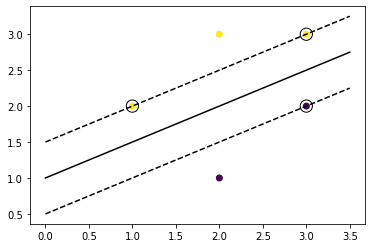

In [19]:
import matplotlib.pyplot as plt
import numpy as np
plt.scatter([i[0] for i in x], [i[1] for i in x], c=y)
xaxis = np.linspace(0, 3.5)
w = clf.coef_[0]
a = -w[0] / w[1]
y_sep = a * xaxis - (clf.intercept_[0]) / w[1]
b = clf.support_vectors_[0]
yy_down = a * xaxis + (b[1] - a * b[0])
b = clf.support_vectors_[-1]
yy_up = a * xaxis + (b[1] - a * b[0])
plt.plot(xaxis, y_sep, 'k-')
plt.plot(xaxis, yy_down, 'k--')
plt.plot(xaxis, yy_up, 'k--')
plt.scatter (clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=150, facecolors='none', edgecolors='k')
plt.show()

# + 另一种SMO

另一种参考统计学习方法上的思路，

外层循环选择**违背KKT条件最严重**的 $\alpha$ 作为 $\alpha_i$，首先遍历间隔边界上的点（ $0 \lt \alpha_i \lt C$ ），如果这些点都满足KKT条件，则遍历所有样本点。

内层循环选择启发式方法选择：

* 如果 $E_i$ 为正，选择最小的 $E$ 作为 $E_j$；如果 $E_i$ 为负，选择最大的 $E$ 作为 $E_j$。（总之使步长最大）
* 如果上一步都不能使目标函数有足够的下降，则遍历间隔边界上的支持向量点，依次将其作为 $\alpha_j$ 使用。
* 如果都不能使目标函数有足够的下降，则遍历训练集的所有向量点，依次将其作为 $\alpha_j$ 使用。
* 如果所有点都不能使目标函数有足够的下降，则放弃当前 $\alpha_i$ ，通过外层循环生成新的 $\alpha_i$ 。


参考[fengdu78/lihang-code](https://github.com/fengdu78/lihang-code)的实现代码：

In [20]:
class SVM:
    def __init__(self, max_iter=100, kernel='linear'):
        self.max_iter = max_iter
        self._kernel = kernel

    def init_args(self, features, labels):
        self.m, self.n = features.shape
        self.X = features
        self.Y = labels
        self.b = 0.0

        # 将Ei保存在一个列表里
        self.alpha = np.ones(self.m)
        self.E = [self._E(i) for i in range(self.m)]
        # 松弛变量
        self.C = 1.0

    def _KKT(self, i):
        y_g = self._g(i) * self.Y[i]
        if self.alpha[i] == 0:
            return y_g >= 1
        elif 0 < self.alpha[i] < self.C:
            return y_g == 1
        else:
            return y_g <= 1

    # g(x)预测值，输入xi（X[i]）
    def _g(self, i):
        r = self.b
        for j in range(self.m):
            r += self.alpha[j] * self.Y[j] * self.kernel(self.X[i], self.X[j])
        return r

    # 核函数
    def kernel(self, x1, x2):
        if self._kernel == 'linear':
            return sum([x1[k] * x2[k] for k in range(self.n)])
        elif self._kernel == 'poly':
            return (sum([x1[k] * x2[k] for k in range(self.n)]) + 1)**2

        return 0

    # E（x）为g(x)对输入x的预测值和y的差
    def _E(self, i):
        return self._g(i) - self.Y[i]

    def _init_alpha(self):
        # 外层循环首先遍历所有满足0<a<C的样本点，检验是否满足KKT
        index_list = [i for i in range(self.m) if 0 < self.alpha[i] < self.C]
        # 否则遍历整个训练集
        non_satisfy_list = [i for i in range(self.m) if i not in index_list]
        index_list.extend(non_satisfy_list)

        for i in index_list:
            if self._KKT(i):
                continue

            E1 = self.E[i]
            # 如果E2是+，选择最小的；如果E2是负的，选择最大的
            if E1 >= 0:
                j = min(range(self.m), key=lambda x: self.E[x])
            else:
                j = max(range(self.m), key=lambda x: self.E[x])
            return i, j

    def _compare(self, _alpha, L, H):
        if _alpha > H:
            return H
        elif _alpha < L:
            return L
        else:
            return _alpha

    def fit(self, features, labels):
        self.init_args(features, labels)

        for t in range(self.max_iter):
            # train
            i1, i2 = self._init_alpha()

            # 边界
            if self.Y[i1] == self.Y[i2]:
                L = max(0, self.alpha[i1] + self.alpha[i2] - self.C)
                H = min(self.C, self.alpha[i1] + self.alpha[i2])
            else:
                L = max(0, self.alpha[i2] - self.alpha[i1])
                H = min(self.C, self.C + self.alpha[i2] - self.alpha[i1])

            E1 = self.E[i1]
            E2 = self.E[i2]
            # eta=K11+K22-2K12
            eta = self.kernel(self.X[i1], self.X[i1]) + self.kernel(
                self.X[i2],
                self.X[i2]) - 2 * self.kernel(self.X[i1], self.X[i2])
            if eta <= 0:
                # print('eta <= 0')
                continue

            alpha2_new_unc = self.alpha[i2] + self.Y[i2] * (
                E1 - E2) / eta  #此处有修改，根据书上应该是E1 - E2，书上130-131页
            alpha2_new = self._compare(alpha2_new_unc, L, H)

            alpha1_new = self.alpha[i1] + self.Y[i1] * self.Y[i2] * (
                self.alpha[i2] - alpha2_new)

            b1_new = -E1 - self.Y[i1] * self.kernel(self.X[i1], self.X[i1]) * (
                alpha1_new - self.alpha[i1]) - self.Y[i2] * self.kernel(
                    self.X[i2],
                    self.X[i1]) * (alpha2_new - self.alpha[i2]) + self.b
            b2_new = -E2 - self.Y[i1] * self.kernel(self.X[i1], self.X[i2]) * (
                alpha1_new - self.alpha[i1]) - self.Y[i2] * self.kernel(
                    self.X[i2],
                    self.X[i2]) * (alpha2_new - self.alpha[i2]) + self.b

            if 0 < alpha1_new < self.C:
                b_new = b1_new
            elif 0 < alpha2_new < self.C:
                b_new = b2_new
            else:
                # 选择中点
                b_new = (b1_new + b2_new) / 2

            # 更新参数
            self.alpha[i1] = alpha1_new
            self.alpha[i2] = alpha2_new
            self.b = b_new

            self.E[i1] = self._E(i1)
            self.E[i2] = self._E(i2)
        return 'train done!'

    def predict(self, data):
        r = self.b
        for i in range(self.m):
            r += self.alpha[i] * self.Y[i] * self.kernel(data, self.X[i])

        return 1 if r > 0 else -1

    def score(self, X_test, y_test):
        right_count = 0
        for i in range(len(X_test)):
            result = self.predict(X_test[i])
            if result == y_test[i]:
                right_count += 1
        return right_count / len(X_test)

    def _weight(self):
        # linear model
        yx = self.Y.reshape(-1, 1) * self.X
        self.w = np.dot(yx.T, self.alpha)
        return self.w

In [23]:
from sklearn.model_selection import  train_test_split
svm = SVM(max_iter=200)
svm.fit(np.array(X_train), np.array(y_train))
svm.score(X_test, y_test)

0.55

感觉比sklearn的默认状态要弱很多。。